
[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\JuHoon\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


공간이 부족하여 Product_1을 배치할 수 없습니다.


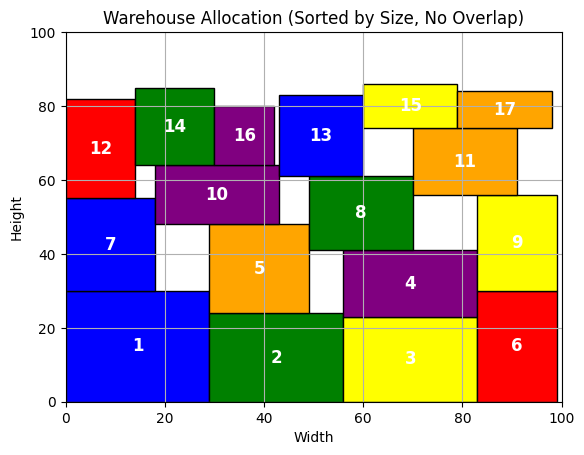


파편화 영역의 개수: 7
평균 빈 공간 크기: 379.00

제거된 재고 개수: 3
제거된 재고 1: 위치 (0, 55), 크기 (14x27)
제거된 재고 2: 위치 (49, 41), 크기 (21x20)
제거된 재고 3: 위치 (79, 74), 크기 (19x10)


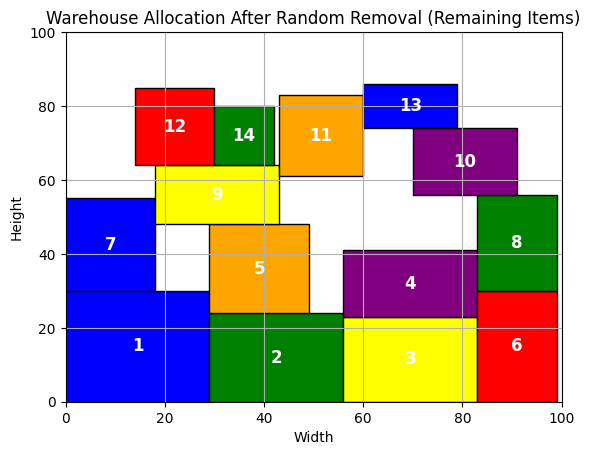

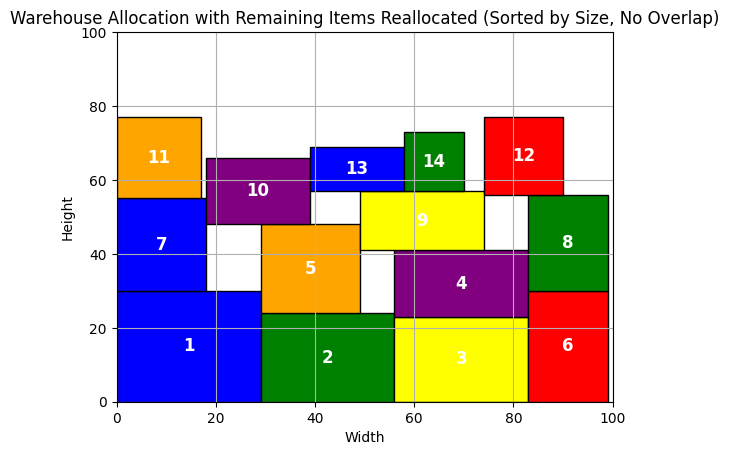

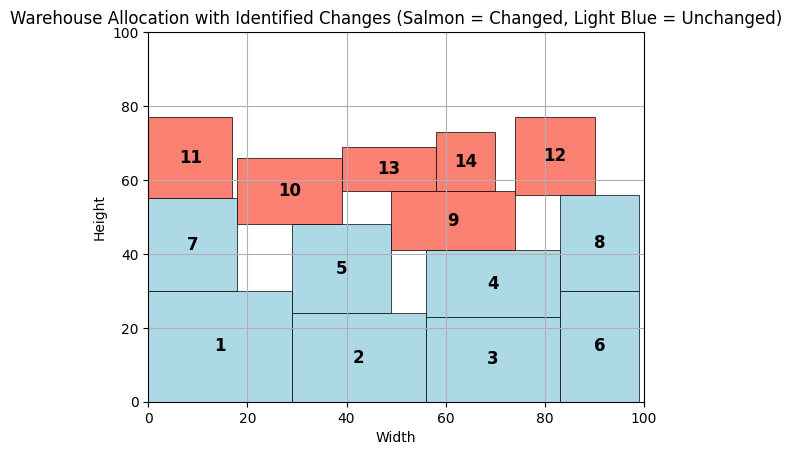


위치가 변경된 항목:
Item 9: New Position (49, 41), Size (25x16)
Item 10: New Position (18, 48), Size (21x18)
Item 11: New Position (0, 55), Size (17x22)
Item 12: New Position (74, 56), Size (16x21)
Item 13: New Position (39, 57), Size (19x12)
Item 14: New Position (58, 57), Size (12x16)

위치가 변경되지 않은 항목:
Item 1: Original Position (0, 0), Size (29x30)
Item 2: Original Position (29, 0), Size (27x24)
Item 3: Original Position (56, 0), Size (27x23)
Item 4: Original Position (56, 23), Size (27x18)
Item 5: Original Position (29, 24), Size (20x24)
Item 6: Original Position (83, 0), Size (16x30)
Item 7: Original Position (0, 30), Size (18x25)
Item 8: Original Position (83, 30), Size (16x26)


In [ ]:
!pip install pulp
import pulp
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque

# 창고 크기 입력
warehouse_columns = int(input("창고의 가로 크기(n)를 입력하세요: "))
warehouse_rows = int(input("창고의 세로 크기(m)를 입력하세요: "))
warehouse_size = warehouse_columns * warehouse_rows

# 창고 면적의 N%에 해당하는 목표 재고 총 면적
target_area = warehouse_size * 0.8

# 재고의 최소 및 최대 가로, 세로 크기 (5, 30으로 고정)
min_width, max_width = 5, 30
min_height, max_height = 5, 30

# 재고 생성 (총 재고 면적이 창고의 N%가 될 때까지)
total_area = 0
product_sizes = {}
product_id = 1

while total_area < target_area:
    width = random.randint(min_width, max_width)
    height = random.randint(min_height, max_height)
    item_area = width * height

    product_sizes[f'Product_{product_id}'] = (width, height)
    total_area += item_area
    product_id += 1

# 최적화 문제 설정 (최소 창고 면적 사용)
problem = pulp.LpProblem("Warehouse_Allocation", pulp.LpMinimize)

# 각 재고에 대한 할당 변수 정의
allocation_variables = pulp.LpVariable.dicts("Allocate", product_sizes.keys(), lowBound=1, cat='Integer')

# 목적 함수: 재고 할당 패널티 부과를 삭제 (모든 재고는 1개만 할당)
problem += pulp.lpSum([allocation_variables[product] * (product_sizes[product][0] * product_sizes[product][1]) for product in product_sizes])

# 제약 조건: 창고의 용량을 초과하지 않도록 설정
problem += pulp.lpSum([allocation_variables[product] * (product_sizes[product][0] * product_sizes[product][1]) for product in product_sizes]) <= warehouse_size

# 문제 해결
problem.solve()

# 빈 공간 찾는 함수
def locate_empty_space(occupied_spaces, width, height, warehouse_columns, warehouse_rows):
    """빈 공간을 찾아 (x, y) 좌표 반환, 없으면 None 반환"""
    for y in range(warehouse_rows):
        for x in range(warehouse_columns):
            if all(not (ox < x + width and ox + ow > x and oy < y + height and oy + oh > y)
                   for ox, oy, ow, oh in occupied_spaces):
                if x + width <= warehouse_columns and y + height <= warehouse_rows:
                    return x, y
    return None

# 재고 크기를 내림차순으로 정렬한 후 배치하는 함수
def place_items_in_warehouse_no_overlap_sorted(product_sizes, warehouse_columns, warehouse_rows):
    """재고 크기 내림차순으로 정렬 후, 겹치지 않게 물건을 창고에 배치하고 시각화"""
    organized_product_sizes = dict(sorted(product_sizes.items(), key=lambda item: item[1][0] * item[1][1], reverse=True))

    occupied_spaces = []  # 배치된 물건 위치 기록
    fig, ax = plt.subplots(1)
    ax.set_xlim(0, warehouse_columns)
    ax.set_ylim(0, warehouse_rows)

    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']

    for i, (product, (width, height)) in enumerate(organized_product_sizes.items(), 1):
        free_space = locate_empty_space(occupied_spaces, width, height, warehouse_columns, warehouse_rows)
        if free_space:
            current_x, current_y = free_space
        else:
            print(f"공간이 부족하여 {product}을 배치할 수 없습니다.")
            break

        # 물건 배치
        rect = patches.Rectangle((current_x, current_y), width, height, linewidth=1, edgecolor='black', facecolor=colors[i % len(colors)])
        ax.add_patch(rect)

        # 중앙에 번호 표시
        ax.text(current_x + width / 2, current_y + height / 2, str(i), color="white", weight="bold", fontsize=12, ha="center", va="center")

        # 이미 사용된 공간을 기록
        occupied_spaces.append((current_x, current_y, width, height))

    plt.title("Warehouse Allocation (Sorted by Size, No Overlap)")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.grid(True)
    plt.show()

    return occupied_spaces

# 빈 공간 파편화 지표 계산 함수
def compute_fragmentation(occupied_spaces, warehouse_columns, warehouse_rows):
    """빈 공간의 파편화 지표를 계산하여 빈 공간 영역의 개수와 평균 크기를 출력"""
    grid = [[1] * warehouse_columns for _ in range(warehouse_rows)]

    # 제품이 있는 위치를 0으로 설정 (빈 공간이 아닌 부분)
    for x, y, width, height in occupied_spaces:
        for i in range(height):
            for j in range(width):
                if 0 <= y + i < warehouse_rows and 0 <= x + j < warehouse_columns:
                    grid[y + i][x + j] = 0  # 차지된 공간 표시

    # 연결된 빈 공간 영역 탐색
    def breadth_first_search(start_x, start_y):
        queue = deque([(start_x, start_y)])
        grid[start_y][start_x] = -1  # 방문 표시
        area_size = 1

        while queue:
            x, y = queue.popleft()
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 상하좌우 탐색
                nx, ny = x + dx, y + dy
                if 0 <= nx < warehouse_columns and 0 <= ny < warehouse_rows and grid[ny][nx] == 1:
                    grid[ny][nx] = -1  # 방문 표시
                    queue.append((nx, ny))
                    area_size += 1

        return area_size

    empty_areas = []

    # 모든 빈 공간을 확인하여 파편화 영역 찾기
    for y in range(warehouse_rows):
        for x in range(warehouse_columns):
            if grid[y][x] == 1:  # 빈 공간이 있으면
                area_size = breadth_first_search(x, y)  # 연결된 빈 공간 크기 확인
                empty_areas.append(area_size)

    # 파편화 지표 출력
    num_areas = len(empty_areas)
    avg_area_size = sum(empty_areas) / num_areas if num_areas > 0 else 0
    print(f"\n파편화 영역의 개수: {num_areas}")
    print(f"평균 빈 공간 크기: {avg_area_size:.2f}")

# 배치 실행 및 파편화 지표 계산
if pulp.LpStatus[problem.status] == 'Optimal':
    occupied_spaces = place_items_in_warehouse_no_overlap_sorted(product_sizes, warehouse_columns, warehouse_rows)
    compute_fragmentation(occupied_spaces, warehouse_columns, warehouse_rows)
else:
    print("최적해를 찾지 못했습니다.")

# 배치된 재고 중 20%를 랜덤하게 제거하는 함수
def remove_random_items(occupied_spaces, percentage=0.2):
    """배치된 재고 중 주어진 백분율(기본 20%)을 랜덤하게 제거"""
    num_to_remove = int(len(occupied_spaces) * percentage)
    removed_items = random.sample(occupied_spaces, num_to_remove)

    # 남아 있는 아이템과 제거된 아이템을 분리
    unallocated_items = [item for item in occupied_spaces if item not in removed_items]

    print(f"\n제거된 재고 개수: {num_to_remove}")
    for idx, (x, y, width, height) in enumerate(removed_items, 1):
        print(f"제거된 재고 {idx}: 위치 ({x}, {y}), 크기 ({width}x{height})")

    return unallocated_items

# 랜덤하게 재고 제거 실행
remaining_spaces = remove_random_items(occupied_spaces)

# 제거 후 남은 재고를 시각화하는 함수
def display_unallocated_items(remaining_spaces, warehouse_columns, warehouse_rows):
    """제거 후 남은 재고를 시각화"""
    fig, ax = plt.subplots(1)
    ax.set_xlim(0, warehouse_columns)
    ax.set_ylim(0, warehouse_rows)

    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']

    for i, (x, y, width, height) in enumerate(remaining_spaces, 1):
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='black', facecolor=colors[i % len(colors)])
        ax.add_patch(rect)

        # 중앙에 번호 표시
        ax.text(x + width / 2, y + height / 2, str(i), color="white", weight="bold", fontsize=12, ha="center", va="center")

    plt.title("Warehouse Allocation After Random Removal (Remaining Items)")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.grid(True)
    plt.show()

# 남은 재고 시각화
display_unallocated_items(remaining_spaces, warehouse_columns, warehouse_rows)

# remaining_spaces를 초기 배치 방식으로 재배치하는 함수
def optimize_allocation(remaining_spaces, warehouse_columns, warehouse_rows):
    """남은 재고를 초기 배치 방식으로 내림차순 정렬 후 다시 배치하고 시각화"""
    # 남은 재고 크기 내림차순 정렬
    sorted_remaining_spaces = sorted(remaining_spaces, key=lambda item: item[2] * item[3], reverse=True)

    # 재배치된 공간을 저장할 리스트
    reallocated_spaces = []

    # 창고 시각화 설정
    fig, ax = plt.subplots(1)
    ax.set_xlim(0, warehouse_columns)
    ax.set_ylim(0, warehouse_rows)
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']

    # 빈 공간에 남은 재고 재배치
    for i, (x, y, width, height) in enumerate(sorted_remaining_spaces, 1):
        free_space = locate_empty_space(reallocated_spaces, width, height, warehouse_columns, warehouse_rows)
        if free_space:
            current_x, current_y = free_space
            # 물건 배치
            rect = patches.Rectangle((current_x, current_y), width, height, linewidth=1, edgecolor='black', facecolor=colors[i % len(colors)])
            ax.add_patch(rect)
            ax.text(current_x + width / 2, current_y + height / 2, str(i), color="white", weight="bold", fontsize=12, ha="center", va="center")
            # 배치된 공간 추가
            reallocated_spaces.append((current_x, current_y, width, height))
        else:
            print(f"공간이 부족하여 재배치할 수 없는 물품이 있습니다.")

    # 창고 배치 시각화
    plt.title("Warehouse Allocation with Remaining Items Reallocated (Sorted by Size, No Overlap)")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.grid(True)
    plt.show()

    return reallocated_spaces

# 남은 재고 재배치 실행
reallocated_spaces = optimize_allocation(remaining_spaces, warehouse_columns, warehouse_rows)

# remaining_spaces를 초기 배치 방식으로 재배치하고 변경 여부를 색상으로 시각화하는 함수
def reallocate_and_visualize_changes_with_color(remaining_spaces, warehouse_columns, warehouse_rows):
    """남은 재고를 초기 배치 방식으로 재배치하고, 위치 변경 여부를 색상으로 시각화"""
    # 남은 재고 크기 내림차순 정렬
    sorted_remaining_spaces = sorted(enumerate(remaining_spaces), key=lambda item: item[1][2] * item[1][3], reverse=True)

    # 재배치된 공간을 저장할 리스트
    reallocated_spaces = []
    changed_items = []
    unchanged_items = []

    # 창고 시각화 설정
    fig, ax = plt.subplots(1)
    ax.set_xlim(0, warehouse_columns)
    ax.set_ylim(0, warehouse_rows)

    # 빈 공간에 남은 재고 재배치
    for i, (original_index, (x, y, width, height)) in enumerate(sorted_remaining_spaces, 1):
        free_space = locate_empty_space(reallocated_spaces, width, height, warehouse_columns, warehouse_rows)
        if free_space:
            current_x, current_y = free_space
            # 변경 여부 확인
            if (x, y) == (current_x, current_y):
                unchanged_items.append((original_index, x, y, width, height))
                fill_color = 'lightblue'  # 변경되지 않은 항목은 밝은 파란색
            else:
                changed_items.append((original_index, current_x, current_y, width, height))
                fill_color = 'salmon'    # 변경된 항목은 살구색

            # 물건 배치
            rect = patches.Rectangle((current_x, current_y), width, height, linewidth=0.5, edgecolor='black', facecolor=fill_color)
            ax.add_patch(rect)
            ax.text(current_x + width / 2, current_y + height / 2, str(i), color="black", weight="bold", fontsize=12, ha="center", va="center")

            # 배치된 공간 추가
            reallocated_spaces.append((current_x, current_y, width, height))
        else:
            print(f"공간이 부족하여 재배치할 수 없는 물품이 있습니다.")

    # 창고 배치 시각화
    plt.title("Warehouse Allocation with Identified Changes (Salmon = Changed, Light Blue = Unchanged)")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.grid(True)
    plt.show()

    # 결과 출력
    print("\n위치가 변경된 항목:")
    for idx, cx, cy, w, h in changed_items:
        print(f"Item {idx + 1}: New Position ({cx}, {cy}), Size ({w}x{h})")

    print("\n위치가 변경되지 않은 항목:")
    for idx, ox, oy, w, h in unchanged_items:
        print(f"Item {idx + 1}: Original Position ({ox}, {oy}), Size ({w}x{h})")

    return reallocated_spaces, changed_items, unchanged_items

# 남은 재고 재배치 및 변경 여부 색상으로 식별 및 시각화 실행
reallocated_spaces, changed_items, unchanged_items = reallocate_and_visualize_changes_with_color(remaining_spaces, warehouse_columns, warehouse_rows)